# **Project Idea**
The New York City Taxi & Limousine Commission (New York City TLC) needs to have a machine learning model to predict if a customer will not leave a tip. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips.

<br/>   

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.  
<br/>  

# Build a Tree-Based Machine Learning Model 

### **Task 1. Imports and Data loading**

In [6]:
# Import packages and libraries needed to build and evaluate random forest and XGBoost classification models
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [7]:
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

In [8]:
# Load dataset into dataframe
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration dataset
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

In [9]:
# Inspect the first few rows of df0
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [10]:
# Inspect the first few rows of `nyc_preds_means`
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


In [11]:
# Merge the two dataFrames df0 and nyc_preds_means together
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)

df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


### **Task 2. Feature Engineering**

In [12]:
# Display more info about the dataset
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

**Note:** 
Customers who pay cash (`payment_type = 2`) generally have a tip amount of $0. To meet the modeling objective, we'll need to sample the data to select only the customers who pay with credit card (`payment_type = 1`). 

In [21]:
# Subset the data to isolate only customers who paid by credit card
df_ = df0[df0['payment_type'] == 1]

##### **Create `tip_percent` Feature**
There isn't a column that indicates tip percent, which is what we need to create the target variable. 

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  

$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  


In [22]:
# Create tip percent column
# df1['tip_percent'] = df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount'])

df1 = df_.copy()
df1['tip_percent'] = df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount'])

##### **Create `generous` Feature**
This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

In [23]:
# Create 'generous' col (target)
df1['generous']= np.where((df1['tip_percent'] >= 0.2), 1, 0)
df1['generous']

0        1
1        1
2        0
3        1
5        1
        ..
22692    0
22693    0
22695    1
22697    0
22698    0
Name: generous, Length: 15265, dtype: int32

##### **Create `day` Feature**

In [24]:
# Convert pickup and dropoff columns to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

In [25]:
# Create a 'day' column that contains only the day of the week when each passenger was picked up
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

#### **Create Time-of-Day (`am_rush`, `daytime`, `pm_rush`, `nightime`) Features**
Each feature should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:
- `am_rush` = [06:00&ndash;10:00)  
- `daytime` = [10:00&ndash;16:00)  
- `pm_rush` = [16:00&ndash;20:00)  
- `nighttime` = [20:00&ndash;06:00)  

In [26]:
# For now, each new feature should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

In [27]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [28]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head()

0    1
1    0
2    1
3    0
5    0
Name: am_rush, dtype: int64

In [29]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [30]:
# Apply 'daytime' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)

In [31]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [32]:
# Apply 'pm_rush' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

In [33]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [34]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1.apply(nighttime, axis=1)

#### **Create `month` Feature**
Create a `month` feature that contains only the abbreviated name of the month when each passenger was picked up

In [35]:
# Create 'month' feature
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [24]:
# Examine and check the first five rows of the dataframe
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200000,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238095,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.198630,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300000,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200000,1,saturday,0,0,0,1,mar


#### Drop Features
- Drop redundant and irrelevant features as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. 
- The target feature (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [36]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int32  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int32(1), int64(9), object(2)
memory usage: 1.8+ MB


#### Feature Encoding
The `RatecodeID`, `PULocationID`, `DOLocationID`, and `VendorID` are numeric, but they actually encode categorical information. These features need to be made categorical.

In [37]:
# Define list of features to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# Convert each feature to string to make them recognizable to the `get_dummies` method
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

In [38]:
# Convert all features in df1 to categorical (binary) and store the result in a new dataFrame sf2 
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: float64(3), int32(1), int64(5), uint8(338)
memory usage: 6.0 MB


##### Select Evaluation Metric
Before modeling, an evaluation metric should be determined.

In [39]:
# Examine the class balance of the target feature `generous` 
df2['generous'].value_counts(normalize=True)

0    0.651425
1    0.348575
Name: generous, dtype: float64

**Insight** 
- Approximately 1/3 of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is imbalanced, but not extremely so.

- To determine a metric, we should examine the cost of both types of model error:
> 1. **False positives** (the model predicts a tip ≥ 20%, but the customer does not give one)
> 2. **False negatives** (the model predicts a tip < 20%, but the customer gives more)

- **False positives** are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

- **False negatives** are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

- **The model should help taxi drivers make more money, but we don't want this to anger customers. Thus, the evaluation metric should weigh both precision and recall equally.** F<sub>1</sub> score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.

### **Task 3. Building Model**

##### **Split the Data**

In [30]:
# Define target feature (y)
y = df2['generous']

# Define the predictor features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

##### **Random Forest**
The following steps are to create GridSearchCV object.

In [31]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the `GridSearchCV` object `rf1`. Pass to it as arguments:
#  - estimator=`rf`
#  - param_grid=`cv_params`
#  - scoring=`scoring`
#  - cv: define the number of cross-validation folds (`cv=_`)
#  - refit: indicate which evaluation metric to use to select the model (`refit=_`), it is f1 score in this case
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

In [33]:
# Fit the model to the training data
%time                                  # This magic command to tell how much time taken to complete this process
rf1.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring={'precision', 'f1', 'recall', 'accuracy'})

In [34]:
# Use `pickle` to save the model and read it back in. This can be particularly helpful when performing a search over many possible hyperparameter values
import pickle 

# Define a path to the folder where to save the model
path = 'C:/Users/Asaad/Desktop/Data Analytic Projects/Machine Learning/[1] Automatidata Project'
# path = '/home/jovyan/work/'

In [35]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [36]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [37]:
# Examine best average score across all the validation folds
rf1.best_score_

0.33852334819169266

In [38]:
# Examine the best combination of hyperparameters.
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [42]:
# Build `get_train_scores` method to output all of the scores of the model on the training data
def get_train_scores(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                        },
                       )

    return table

In [46]:
# Call 'get_train_scores()' on the GridSearch object
rf_train_scores = get_train_scores('RF CV', rf1, 'f1')
rf_train_scores

,model,precision,recall,F1,accuracy
0,RF CV,0.452301,0.271088,0.338523,0.631182


**Insight** 
- F<sub>1</sub>, precision, and recall scores are loow, so the model is not good enough to predict. More improvement technique should be used (XGBoost in this case).

In [44]:
# Use the model to predict on the test data
preds = rf1.best_estimator_.predict(X_test)

In [45]:
# Build `get_test_scores` method to output all of the scores of the model on the testing data
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                        })

    return table

###### RF test results

In [47]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', preds, y_test)
results = pd.concat([rf_train_scores, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.452301,0.271088,0.338523,0.631182
0,RF test,0.460938,0.277256,0.346244,0.635113


**Insight** 
- All scores increased by < 0.01

##### **XGBoost For Improvement**

In [53]:
# 1. Instantiate the XGBoost classifier object
xgb_classifier = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb = GridSearchCV(xgb_classifier, cv_params, scoring=scoring, cv=4, refit='f1')

In [54]:
# Now, fit the model to the training data
%time
xgb.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring={'precision', 'f1', 'recall', 'accuracy'})

In [55]:
# Examine best score
xgb.best_score_

0.35784636560658645

In [56]:
# Examine best parameters
xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

In [59]:
# Call 'get_train_scores()' on the GridSearch object
xgb_cv_results = get_train_scores('XGB CV', xgb, 'f1')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.452301,0.271088,0.338523,0.631182
0,RF test,0.460938,0.277256,0.346244,0.635113
0,XGB CV,0.445599,0.299513,0.357846,0.625696
0,XGB CV,0.445599,0.299513,0.357846,0.625696
0,XGB CV,0.445599,0.299513,0.357846,0.625696


In [60]:
# Get scores on test data
preds = xgb.best_estimator_.predict(X_test)

In [61]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.452301,0.271088,0.338523,0.631182
0,RF test,0.460938,0.277256,0.346244,0.635113
0,XGB CV,0.445599,0.299513,0.357846,0.625696
0,XGB CV,0.445599,0.299513,0.357846,0.625696
0,XGB CV,0.445599,0.299513,0.357846,0.625696
0,XGB test,0.456884,0.283835,0.350145,0.632820


**Insight** 
- The F<sub>1</sub> score is ~0.04 higher than the random forest model. Both models are still unsatisfactory, though.

#### **Plot a Confusion Matrix to Evaluate the Model's Predictions on the Test Data**

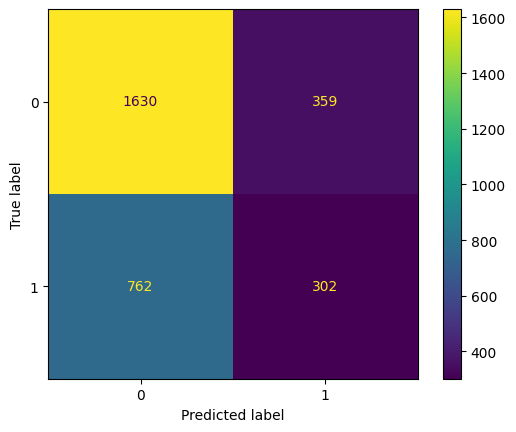

In [62]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, preds, labels=xgb.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()

**Insight:** 
- The model is twice as likely to predict a false negative than it is to predict a false positive. Therefore, type II errors are more common. For our use case, this would be more desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, it's unlikely that this model would be deployed without further development to significantly improve its performance.

##### Feature Importance
- Use the `plot_importance` function to inspect the top 10 most important features of the final model

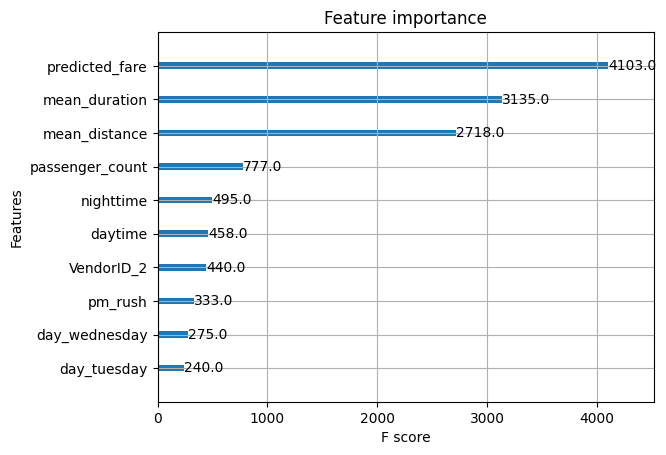

In [63]:
plot_importance(xgb.best_estimator_, max_num_features=10)

### **Task 4. Executive Summary**
1. This is not a great model, but depending on how it's used it could still be useful. If the objective is only to help give taxi drivers a better idea of whether someone will leave a good tip, then it could be useful. It may be worthwhile to test it with a select group of taxi drivers to get feedback.

2. Unfortunately, XGBoost is not the most transparent machine learning algorithm. We know that `predicted_fare`, `mean_duration`, and `mean_distance` are the most important features, but we don't know how they influence tipping. This would require further exploration.

3. There are almost always additional features that can be engineered, but hopefully the most obvious ones were generated during the first round of modeling. In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of $5) / fare amount. For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10.


$$round5\_ratio = \frac{amount\ of\ money\ from\ the\ fare\ amount\ to\ the\ nearest\ higher\ multiple\ of\ $5}{fare\ amount}$$   

  <details>
    <summary><h5>HINT</h5></summary>
  $$ = \frac{5 - (fare\ mod\ 5)}{fare\ amount}$$  
  </details>

4. It would probably be very helpful to have past tipping behavior for each customer. 
5. It would also be valuable to have accurate tip values for customers who pay with cash.
6. It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.